## Dimensionality Reduction & Model Parsimony

A challenge for many machine learning scenarios is dealing with overfitting. This becomes more challenging when we have relatively small amounts of data and/or a potentially complex data (and thus a correspondingly complex model). I'm a big fan of this quote from John von Neumann.

### _With four parameters I can fit an elephant, and with five I can make him wiggle his trunk._

See this [cool notebook](https://www.johndcook.com/blog/2011/06/21/how-to-fit-an-elephant/) for an elephant plotted from complex numbers. 

We have quite a small dataset of images in the Open hack challenges and so managing overfitting and model complexity needs to be front of mind. In this notebook I walk through some of the intuitive discusions that I have with my team to help them to understand some potential approaches.I like to start with stuff that's quite intuitive and I also like to pose _reductio ad absurdum_ questions. I share some of these below.

Ultimately in this challenge we are tasked with building a simple ML model to classify our gear images. I use an approach that was considered state of the art some 20 odd years ago when I was in college. This is the _eigenfaces_ or _eigenimage_ approach. See [here](https://en.wikipedia.org/wiki/Eigenface) for a bit more detail. 

We use [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) reduce the dimensionality of the data. Then we train a Support Vector Machine with Radial Basis Function kernel (and yes, an RBF kernel means it's non-parametric!) on the first few eigenvalues as a supervised model. 

This is based on the tutorial [here](http://www.scipy-lectures.org/packages/scikit-learn/auto_examples/plot_eigenfaces.html).

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imread, imshow, show, subplot, title, get_cmap, hist
import numpy as np
from PIL import Image, ImageOps, ImageChops
import cv2
import os
import pickle

#Inline Matplot graphics into the notebook
%matplotlib inline 


# From: https://gist.github.com/fabeat/6621507
# Using the version in the comments to the Gist
# Best practice default is using Bicubic rather than Antialias per http://pillow.readthedocs.io/en/3.0.x/releasenotes/2.7.0.html#default-filter-for-thumbnails
def scale(image, max_size=(128,128), method=Image.BICUBIC):
    """
    resize 'image' to 'max_size' keeping the aspect ratio
    and place it in center of white 'max_size' image
    """
    image.thumbnail(max_size, method)
    offset = (int((max_size[0] - image.size[0]) // 2), int((max_size[1] - image.size[1]) // 2))
    back = Image.new("RGB", max_size, "white")
    back.paste(image, offset)

    return back




### An intuitive discussion on dimensionality reduction
Our dataset consists of a relatively small number of quite high dimensional labeled examples. That is to say we have just a few thousand images, but, each of those images has a dimensionality of ~50,000 (128 pixels by 128 pixels by 3 colour channels). 

The first discussion I like to have with my team is about getting rid of extraneous data. Data than may have patterns in the training set, but, that probably will not generalize well to new data.

![Various Gear](images/all.jpg) 

I simply ask my team to take a look at the images in the folder and tell m if they intuitively think that colour isgoing to be a good and generalizable predictor on future data. Literally, have them open the folders of images; __they're all a rainbow of bright images__. Thanks to marvels of modern technology, even crampons can now be anodized into wonderful bright colours.

Team members should experiment with dropping colour from their input data and test whether it improves model performance on a hold-out set or via cross-validation.

In [4]:
gear_images_dir = "../gear_images"
data = list()
labels = list()
images = list()
for directory in os.listdir(gear_images_dir):
    current_dir = gear_images_dir + '/' + directory
    print('Loading images from: {}'.format(current_dir))
    for imgName in os.listdir(os.fsencode(current_dir)):
        #print('Loading: {}'.format(os.fsdecode(imgName)))
        image = Image.open(current_dir + '/' + os.fsdecode(imgName)) #Open as greyscale
        image = ImageOps.equalize(scale(image))
        images.append(image.convert('LA'))
        data.append(np.asarray(image.convert('L')).flatten())
        labels.append(directory)
    print('Done')   

Loading images from: ../gear_images/hardshell_jackets
Done
Loading images from: ../gear_images/pulleys
Done
Loading images from: ../gear_images/crampons
Done
Loading images from: ../gear_images/harnesses
Done
Loading images from: ../gear_images/boots
Done
Loading images from: ../gear_images/gloves
Done
Loading images from: ../gear_images/rope
Done
Loading images from: ../gear_images/axes
Done
Loading images from: ../gear_images/helmets
Done
Loading images from: ../gear_images/insulated_jackets
Done
Loading images from: ../gear_images/tents
Done
Loading images from: ../gear_images/carabiners
Done


In [5]:
data_array = np.asarray(data)
print(data_array.shape)

label_array = np.asarray(labels)
print(label_array.shape)

labels.sort()

(2129, 16384)
(2129,)


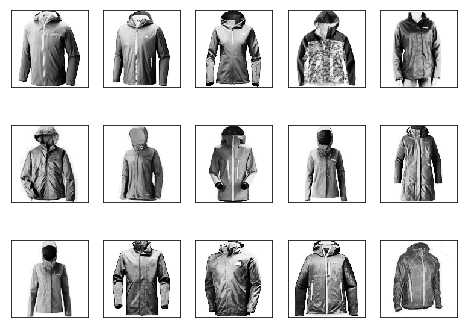

In [8]:
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(images[i], cmap=plt.cm.bone)

In [9]:
#Split out a test set.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_array,
        label_array, random_state=0)

print(X_train.shape, X_test.shape)

(1596, 16384) (533, 16384)


### Principal Component Analysis (PCA)
Even after removing colour we still have very high dimensionality data. We will use an approach called Principal Component Analysis to reduce the dimensions even further. PCA is a very common approach to dimensionality reduction. The detailed mathematics of how it works probably aren't something you'll want/need to cover off with your team, but, I think it's good to share the intuitive understanding of how it works and for this I am a big fan of the [Explained Visually] (http://setosa.io/ev/principal-component-analysis/).

PCA emphasizes the variation in the dataset. Effectively it projects the data into a new space such that the first principal component maximizes the variance across the data, the second principal component will then be orthogonal to the first and will maximize the remaining variance and so on. This is really easy to understand in two or three dimensions...

![PCA Image](https://upload.wikimedia.org/wikipedia/commons/f/f5/GaussianScatterPCA.svg) image from Wikipedia.

We decompose our data into the first 150 principal components. This number is something that you might like your teams to experiment. have them explain what the trade-offs are as they change this.

In [10]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=150, whiten=True)
pca.fit(X_train)
pickle.dump(pca, open( "pca.p", "wb" ) )
file = open("pca.p",'rb')
pca = pickle.load(file)

We can draw the 'average' image. We can see straight away the effective of having a disproportionately large number of jackets in our dataset. Have team members think a bit about this? Might it cause problems for our model? What are some ideas to solve this? _Hint:_ Think about things like undersampling and oversampling of the data. This leads in well into topics such as data augmentation later on.

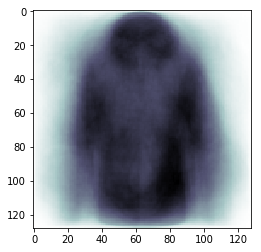

In [11]:
plt.imshow(pca.mean_.reshape(np.asarray(images[0].convert('L')).shape),
           cmap=plt.cm.bone)

We can visualize the principal components

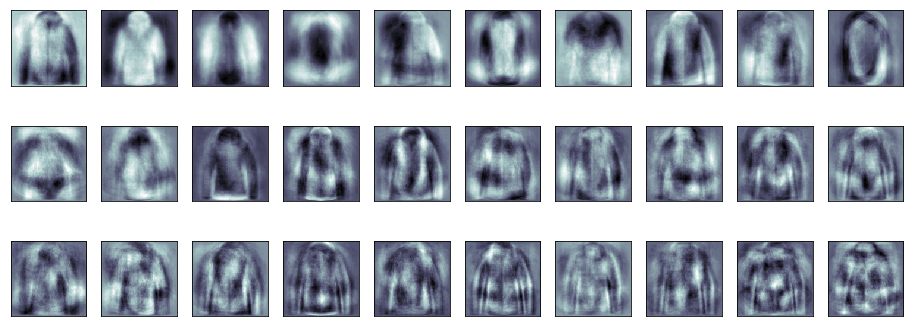

In [12]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(np.asarray(images[0].convert('L')).shape),
              cmap=plt.cm.bone)

In [13]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)

(1596, 150)
(533, 150)


Now we can fit an SVM with RBF kernel to the data. This is the supervised model.

In [15]:
from sklearn import svm
clf = svm.SVC(C=5., kernel='rbf', gamma=0.001)
clf.fit(X_train_pca, y_train)
pickle.dump(clf, open( "svm.p", "wb" ) )

### A reasonable model
The model does a reasonable job of predicting outcomes. It will not be particularly robust to scale and rotational transforms but it's pretty impressive for such a simple model. Intuitively, what classes do we think the model might struggle with? Probably hardshell vs insulated jacket?

The confusion matrix also gives some indication as to the un-balanced nature of our dataset; compare the _fpr_ for jackets and note the skew towards hardshell jackets resultin from our training set having twice as much data for hardshell jackets. 

### How simple could we go?
I like to leave my team to think a bit abou just how simple a model could they build here? The examle that I like to give is that we could probably build a model with at least some predictive power using just a single dimension;

_Think about how you could build a model using just a single dimension; a count of the number of white pixels in the image_... Do you think that this sort of model would have some predictive power?

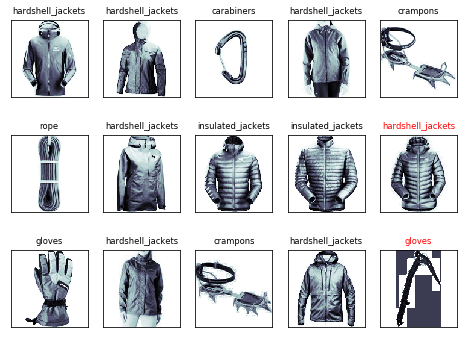

In [20]:
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(np.asarray(images[0].convert('L')).shape),
              cmap=plt.cm.bone)
    y_pred = clf.predict(X_test_pca[i, np.newaxis])[0]
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred,
                 fontsize='small', color=color)

In [17]:
from sklearn import metrics
y_pred = clf.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

             axes       0.81      0.94      0.87        18
            boots       0.85      0.82      0.84        28
       carabiners       0.92      0.90      0.91        68
         crampons       1.00      0.88      0.94        34
           gloves       0.69      0.88      0.77        48
hardshell_jackets       0.82      0.97      0.89       116
        harnesses       1.00      0.90      0.95        39
          helmets       1.00      0.85      0.92        27
insulated_jackets       0.89      0.65      0.75        60
          pulleys       1.00      0.50      0.67        12
             rope       0.95      0.98      0.97        58
            tents       1.00      0.96      0.98        25

      avg / total       0.89      0.88      0.88       533



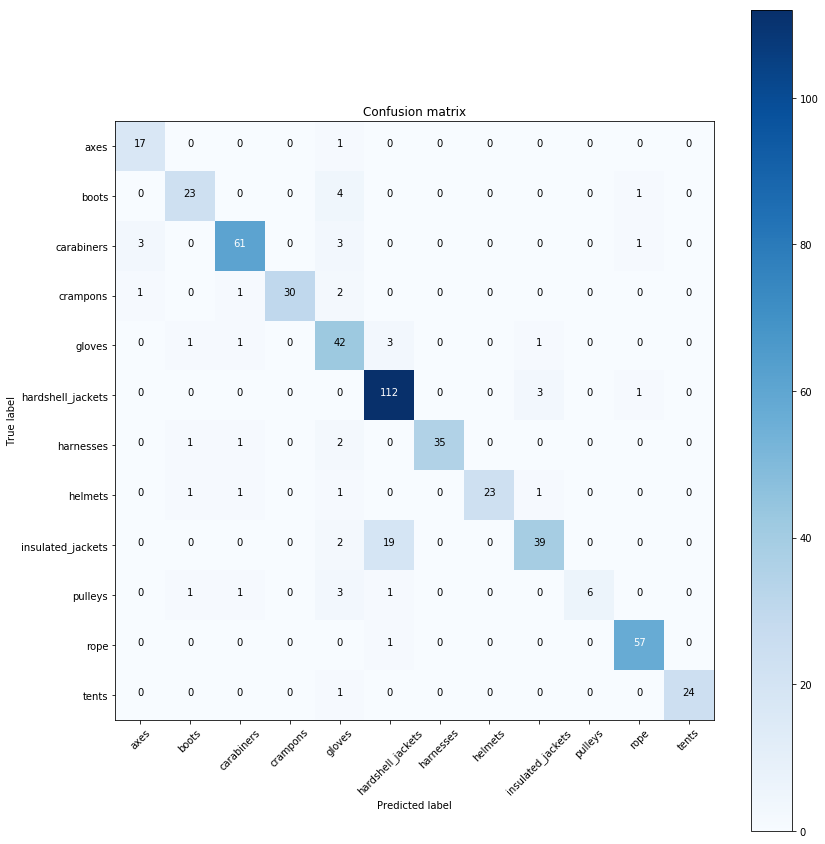

In [18]:
import itertools
# Pretty print CM from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#pint(metrics.confusion_matrix(y_test, y_pred))

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

cm_labels = list(set(labels))
cm_labels.sort()

# Plot non-normalized confusion matrix
plt.figure(figsize=(12, 12))
plot_confusion_matrix(cnf_matrix, classes=cm_labels,
                      title='Confusion matrix')

In [18]:

def predict_class(url):
    import requests
    from io import BytesIO

    images = list()
    data = list()

    response = requests.get(url)
    image = Image.open(BytesIO(response.content))

    image = ImageOps.equalize(scale(image))
    images.append(image.convert('LA'))
    data.append(np.asarray(image.convert('L')).flatten())

    file = open("pca.p",'rb')
    pca = pickle.load(file)

    file = open("svm.p",'rb')
    clf = pickle.load(file)


    data_array = np.asarray(data)
    print(data_array.shape)

    X_test_pca = pca.transform(data_array)
    print(X_test_pca.shape)
    y_pred = clf.predict(X_test_pca)
    return y_pred

image_url = "https://www.blackdiamondequipment.com/dw/image/v2/AAKN_PRD/on/demandware.static/-/Sites-bdel/default/dwaad1abaf/products/carabiners_draws/S16/210275_RockLock_Screwgate_Carabiner_web.jpg?sw=472"
print(predict_class(image_url))



(1, 16384)
(1, 150)
['carabiners']
